In [380]:
library(dplyr)
library(RColorBrewer)
library(harmony)
library(ggplot2)
library(pheatmap)
library(cowplot)
require(viper)
require(reshape2)


find_which = function(TF, TFslist, output='cells_string') {
    cells = sapply(TFslist, function(x) TF %in% x) %>% which(.) %>% names(.)
    if(output=='cells_string')
        return(paste(cells, collapse = ',')  )
    if(output=='Ncells')
        return(length(cells))
                   
}

## Load DE expression info

In [381]:
## IN VITRO
# named list of data.frames, and the name 
# "Hormone_in_WNTi_bg" means No hormone vs Hormone, where both clusters are treated WTN inhibitor
# similarly "WNTi_in_Secretory_bg" is ctrl vs WNTi, both subsetted to the celltype clusters matching mature secretory epithelial cells. 
# It contains a "gene" column too
path_DE = '/lustre/scratch117/cellgen/team292/lh20/Sharing/Luz/pairwiseorg_DEtables.rds'
exp_invitro = readRDS(path_DE)
exp_invitro$Hormone_in_WNTi_bg = exp_invitro$Hormone_in_WNTi_bg[ order(exp_invitro$Hormone_in_WNTi_bg$Log2FC, decreasing = T), ]
exp_invitro$NOTCHi_in_Secretory_bg = NULL

# # Build dictionary clusters2DEGs
all_DEGs_invitro = lapply(exp_invitro, function(x) {
    rownames(x) = x$gene
#     x = subset(x, WilcoxLog10Pvalue_fdr_corr < log10(0.01))
    x = subset(x, DESeq2Log10Pvalue_fdr_corr < log10(0.05))
    x$Log2FC = round(x$Log2FC, digits = 2)
    return(x)
} )
# Build dictionary clusters2expressed genes
DEGs_invitro = lapply(all_DEGs_invitro, rownames)
names(DEGs_invitro) = names(all_DEGs_invitro)

In [382]:
DEGs_table = melt(exp_invitro, id.vars = names(exp_invitro[[1]]) )
DEGs_table = cbind(DEGs_table[, 12:13], DEGs_table[, -c(12:13)])
names(DEGs_table)[2] = 'test'
nrow(DEGs_table)
DEGs_table = subset(DEGs_table, 10^DESeq2Log10Pvalue < 0.1)
nrow(DEGs_table)
DEGs_table$comparison = c('WNTi_in_Secretory_bg'='WNTi vs Ctrl in Secretory', 'Hormone_in_WNTi_bg'='E+P vs NH in Secretory WNTi')[ DEGs_table$test  ]
DEGs_table$test = c('WNTi_in_Secretory_bg'='WNTi effect in Secretory', 'Hormone_in_WNTi_bg'='E+P effect in Secretory WNTi')[ DEGs_table$test  ]

write.csv(DEGs_table, file = '/home/jovyan/farm/endometrium_v2/invitro/TFact_Inhi/SecretoryPerturbations_DEGs.csv', row.names = F, quote = F)

[1] 50982

[1] 9444

## Compute TF activities

In [383]:
viper_gset = get(load('~/farm/gsea/genesets/dorotheav2-top10scoring_VentoLab20201111.rdata'))

# For each DEG file
results = list()
for (cl_name in names(exp_invitro)){

  DEsignature = exp_invitro[[cl_name]]    
  DEsignature$Gene = rownames(DEsignature)
    
  # Estimate z-score values for the GES. Cheeck VIPER manual for details
  myStatistics = matrix(DEsignature$Log2FC, dimnames = list(DEsignature$Gene, 'logFC') )
  myPvalue = matrix(10^DEsignature$WilcoxLog10Pvalue, dimnames = list(DEsignature$Gene, 'P.Value') )
  mySignature = (qnorm(myPvalue/2, lower.tail = FALSE) * sign(myStatistics))[, 1]
  mySignature = mySignature[order(mySignature, decreasing = T)]
  
  # Estimate TF activities
  mrs = msviper(ges = mySignature, regulon = viper_gset, minsize = 4, ges.filter = F)
#   mrs = msviper(ges = myStatistics[,1][order(myStatistics[,1], decreasing = T)], regulon = viper_gset, minsize = 3, ges.filter = F)
  cl_enrichment = data.frame(Regulon = names(mrs$es$nes),
                             cluster = cl_name,
                             Size = mrs$es$size[ names(mrs$es$nes) ], 
                             NES = mrs$es$nes, 
                             p.value = mrs$es$p.value, 
                             FDR = p.adjust(mrs$es$p.value, method = 'fdr'))
  cl_enrichment = subset(cl_enrichment, Size < 200)
#   cl_enrichment = subset(cl_enrichment, FDR < 0.1)
  cl_enrichment = cl_enrichment[ order(cl_enrichment$p.value), ]
  if( nrow(cl_enrichment) > 0 )
    results[[cl_name]] = cl_enrichment
}

df = melt(results, id.vars = names(results[[1]]))
df = df[, c(2,1,4:6,3)]
ALL_TFact_invitro = df[ order(df$p.value, decreasing = F), ]
ALL_TFact_invitro$TF = gsub('_AA', '', ALL_TFact_invitro$Regulon)
ALL_TFact_invitro$TF = gsub('_[B-E]', '', ALL_TFact_invitro$TF)

ALL_TFact_invitro$comparison = c('WNTi_in_Secretory_bg'='WNTi vs Ctrl in Secretory', 'Hormone_in_WNTi_bg'='E+P vs NH in Secretory in WNTi')[ ALL_TFact_invitro$cluster  ]
ALL_TFact_invitro$test = c('WNTi_in_Secretory_bg'='WNTi effect in Secretory', 'Hormone_in_WNTi_bg'='E+P effect in Secretory in WNTi')[ ALL_TFact_invitro$cluster  ]
write.csv(ALL_TFact_invitro, file = '/home/jovyan/farm/endometrium_v2/invitro/TFact_Inhi/SecretoryPerturbations_TFs_activities.csv', row.names = F, quote = F)

Computing regulon enrichment with aREA algorithm



  |======================================================================| 100%

Computing regulon enrichment with aREA algorithm



  |======================================================================| 100%

In [384]:
# Build dictionary activated TFs
all_TFact_invitro = subset(ALL_TFact_invitro, FDR < 0.05)
TFact_invitro = lapply(unique(all_TFact_invitro$cluster),
      function(cl)
          subset(all_TFact_invitro, cluster == cl)$TF
)
names(TFact_invitro) = unique(all_TFact_invitro$cluster)

# Compare

In [385]:
TFs = ALL_TFact_invitro %>%
        select(TF)
TFs =  TFs$TF

In [386]:
# Genes of interest
sharedTFs = mapply(c, TFact_invitro, DEGs_invitro)

In [387]:
TF_selected_ciliated = read.csv('merged/TF_Ciliated_selected.csv', stringsAsFactors = F)
TF_selected_glandular = read.csv('merged/TF_Glandular_selected.csv', stringsAsFactors = F)

shared_invivo = lapply(sharedTFs, intersect, c(TF_selected_glandular$invivo, TF_selected_ciliated$invivo))
shared_invivo

$WNTi_in_Secretory_bg
[1] "FOXJ1" "HIF1A" "PPARG" "HEY1"  "HES4"  "HNF1B" "FOSL2" "MYB"   "FOXO1"

$Hormone_in_WNTi_bg
[1] "CSRNP1" "HIF1A"  "HES6"   "HNF1B"  "TP73"   "HOXC4"  "FOXJ1"  "RFX2"

In [388]:
cuColors = c('#c466b0', '#779eed', '#71a2c7', '#60bddb',   '#70ccbe', 
               '#91bd80', '#bdb380',  '#d4db81',  '#dba781', '#e08b8b', 
               '#d96884', '#d9a5c3', '#cc8fdb')

get_dfPloter_DE = function(df, id = 'Hormone_in_WNTi_bg'){
    df = subset(df, gene %in% TFs)
    df = df[ order(df$DESeq2Log10Pvalue_fdr_corr) ,]
    df$label_gene2 = ''
#     df$label_gene2[1:6] = df$gene[1:6]
    df$TFactive = df$gene %in% TFact_invitro[[id]]
    df$is_DE = df$gene %in% DEGs_invitro[[id]]
    df$label = 'grey99'
    df$label[ df$TFactive ] = 'grey66'
    df$label[ df$is_DE  ] = cuColors[2]
    df$label[ df$is_DE  & df$TFactive ] = cuColors[8]
    df$label_gene = ''
    df$label_gene[ df$gene %in% unlist(shared_invivo)  ] = 
    df$gene[ df$gene %in% unlist(shared_invivo)  ]
    df$label_gene[ ! df$is_DE & ! df$TFactive ] = ''
    df$label_gene2[ df$label_gene != ''] = ''
    return(df)
}

library(ggrepel)

Warning message:
“Ignoring unknown parameters: fill”
Warning message:
“Removed 17 rows containing missing values (geom_text_repel).”
Warning message:
“Removed 17 rows containing missing values (geom_label_repel).”
Saving 6.67 x 6.67 in image

Warning message:
“Removed 17 rows containing missing values (geom_text_repel).”
Warning message:
“Removed 17 rows containing missing values (geom_label_repel).”
Warning message:
“Ignoring unknown parameters: fill”
Warning message:
“Removed 23 rows containing missing values (geom_text_repel).”
Warning message:
“Removed 23 rows containing missing values (geom_label_repel).”


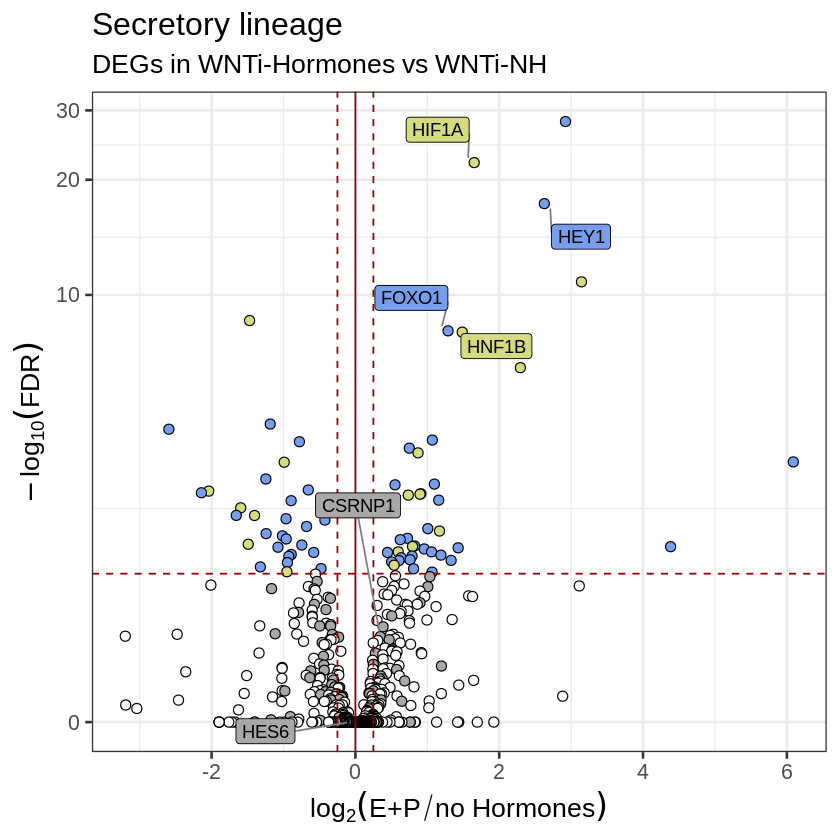

Saving 6.67 x 6.67 in image

Warning message:
“Removed 23 rows containing missing values (geom_text_repel).”
Warning message:
“Removed 23 rows containing missing values (geom_label_repel).”


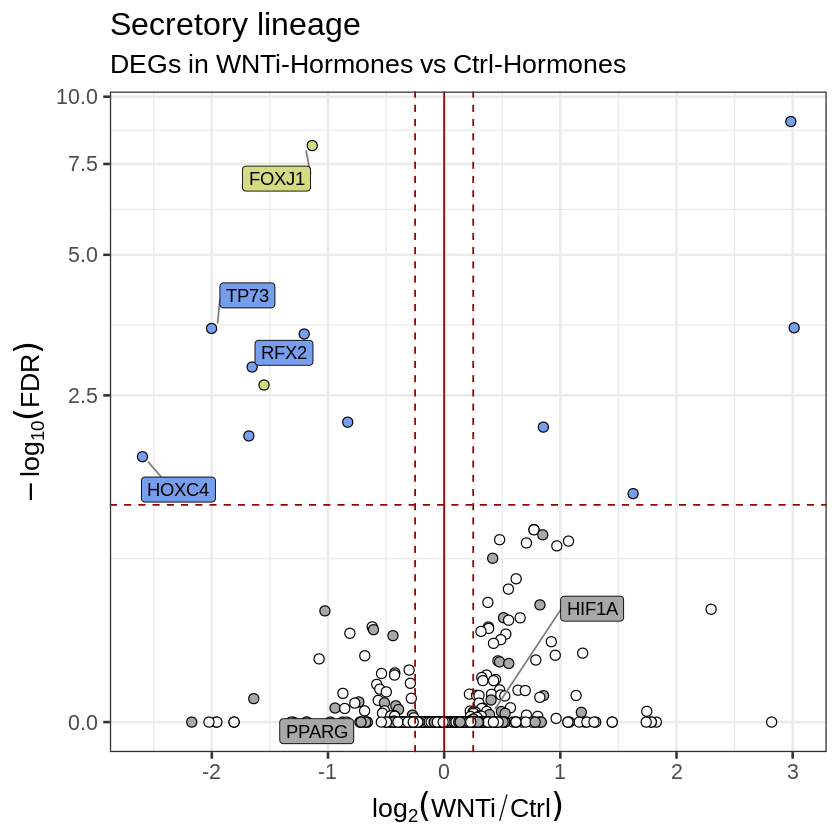

In [389]:
df = get_dfPloter_DE(exp_invitro$Hormone_in_WNTi_bg)
vol <- ggplot(df, aes(x = Log2FC, y = -DESeq2Log10Pvalue_fdr_corr, fill = label, label=label_gene)) + 
          ggtitle(label = "Secretory lineage", subtitle = "DEGs in WNTi-Hormones vs WNTi-NH") +
          scale_fill_identity() +
#           scale_x_continuous(limits = c(-3, 3.5))+
          geom_point(size = 2.5, alpha = 1, na.rm = T, shape = 21, colour = "black") +
          theme_bw(base_size = 16) + # change overall theme
          theme(legend.position = "right") + # change the legend
          xlab(expression(log[2]("E+P" / "no Hormones"))) + # Change X-Axis label
          ylab(expression(-log[10]("FDR"))) + # Change Y-Axis label
          geom_hline(yintercept = 1.3, colour="#990000", linetype="dashed") + 
          geom_vline(xintercept = 0.25, colour="#990000", linetype="dashed") + 
          geom_vline(xintercept = 0, colour="#990000") + 
          geom_vline(xintercept = -0.25, colour="#990000", linetype="dashed") + # Add p-adj value cutoff line
          scale_y_continuous(trans = "log1p") + # Scale yaxis due to large p-values
          geom_text_repel(aes(label=label_gene2), box.padding   = 0, point.padding = 0.5, segment.color = 'grey50', fill = 'white') +
          geom_label_repel(aes(label=label_gene), box.padding   = 0.35, point.padding = 0.5, segment.color = 'grey50')
vol
ggsave(filename = 'invitro/inhibidors_Hormone_in_WNTi_volcanoDEGs.pdf', dpi = 300)


df = get_dfPloter_DE(exp_invitro$WNTi_in_Secretory_bg, id = 'WNTi_in_Secretory_bg')
vol <- ggplot(df, aes(x = Log2FC, y = -DESeq2Log10Pvalue_fdr_corr, fill = label, label=label_gene)) + 
          ggtitle(label = "Secretory lineage", subtitle = "DEGs in WNTi-Hormones vs Ctrl-Hormones") +
          scale_fill_identity() +
#           scale_x_continuous(limits = c(-3, 3.5))+
          geom_point(size = 2.5, alpha = 1, na.rm = T, shape = 21, colour = "black") +
          theme_bw(base_size = 16) + # change overall theme
          theme(legend.position = "right") + # change the legend
          xlab(expression(log[2]("WNTi" / "Ctrl"))) + # Change X-Axis label
          ylab(expression(-log[10]("FDR"))) + # Change Y-Axis label
          geom_hline(yintercept = 1.3, colour="#990000", linetype="dashed") + 
          geom_vline(xintercept = 0.25, colour="#990000", linetype="dashed") + 
          geom_vline(xintercept = 0, colour="#990000") + 
          geom_vline(xintercept = -0.25, colour="#990000", linetype="dashed") + # Add p-adj value cutoff line
          scale_y_continuous(trans = "log1p") + # Scale yaxis due to large p-values
          geom_text_repel(aes(label=label_gene2), box.padding   = 0, point.padding = 0.5, segment.color = 'grey50', fill = 'white') +
          geom_label_repel(aes(label=label_gene), box.padding   = 0.35, point.padding = 0.5, segment.color = 'grey50')
vol
ggsave(filename = 'invitro/inhibidors_WNTi_in_Secretory_volcanoDEGs.pdf', dpi = 300)

In [390]:
head(ALL_TFact_invitro)

,cluster,Regulon,NES,p.value,FDR,Size,TF,comparison,test
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<chr>,<chr>
615,WNTi_in_Secretory_bg,FOXJ1_E,-12.460990,1.218478e-35,2.109490e-33,156,FOXJ1,WNTi vs Ctrl in Secretory,WNTi effect in Secretory
1,Hormone_in_WNTi_bg,CSRNP1_E,7.812631,5.600650e-15,2.424031e-13,154,CSRNP1,E+P vs NH in Secretory in WNTi,E+P effect in Secretory in WNTi
2,Hormone_in_WNTi_bg,ZNF749_E,-7.167199,7.654775e-13,2.355970e-11,195,ZNF749,E+P vs NH in Secretory in WNTi,E+P effect in Secretory in WNTi
616,WNTi_in_Secretory_bg,ZSCAN16_E,6.833590,8.281563e-12,1.116931e-10,168,ZSCAN16,WNTi vs Ctrl in Secretory,WNTi effect in Secretory
617,WNTi_in_Secretory_bg,MYC_AA,-6.463885,1.020484e-10,1.197771e-09,145,MYC,WNTi vs Ctrl in Secretory,WNTi effect in Secretory
618,WNTi_in_Secretory_bg,ZNF557_E,6.320854,2.601211e-10,2.814591e-09,183,ZNF557,WNTi vs Ctrl in Secretory,WNTi effect in Secretory


In [391]:
plotHeatmap_TFact = function(df, TFs_of_interest, pdf_file = NA){
    TFs_of_interest = intersect(TFs_of_interest, df$TF)
    # build matrix of TF activity scores to plot
    df$value = df$NES
    NES = acast(df, TF~cluster2, fill = 0)
    NES = NES[TFs_of_interest, ]
    labels = NES
    labels[] = ''
    for( i in rownames(labels) )
        for( j in colnames(labels) ){
            ag = i %in% DEGs_invitro[[j]]
            if( ag )
                labels[i , j] = '*'
            }
        
    pheatmap(t(NES), cellheight = 20, cellwidth = 20, cluster_rows = F, cluster_cols = F, display_numbers = t(labels), fontsize = 20,
             color = colorRampPalette(c(brewer.pal(n = 5, name = 'Blues')[4], "white", brewer.pal(n = 5, name = 'Reds')[4]))(50),
            filename = pdf_file, width=10, height=4)
}

In [392]:
TFs_of_interest = all_TFact_invitro %>%
  group_by(cluster) %>%
  group_map(~ head(.x, 20L))

all_TFact_invitro$cluster2 = c('WNTi_in_Secretory_bg'='WNTi effect', 'Hormone_in_WNTi_bg'='E+P effect')[ all_TFact_invitro$cluster  ]

plotHeatmap_TFact(all_TFact_invitro, TFs_of_interest = setdiff(unlist(shared_invivo), 'HES6'), pdf_file = 'invitro/inhibidors_heatmap_TFact_invivo.pdf')